# K-Nearest Neighbors (KNN) - PyTorch Implementation

Multi-class classification on the **Covertype (Forest Cover Type)** dataset using PyTorch GPU acceleration.

**Dataset**: 581,012 samples, 54 features, 7 forest cover types  
**Task**: Predict forest cover type from cartographic variables  
**Key Concept**: KNN is a "lazy learner" - no training phase, expensive at prediction time

## PyTorch Advantages for KNN
- **`torch.cdist`**: Highly optimized pairwise distance computation
- **GPU acceleration**: RTX 4090 CUDA cores for parallel distance calculations
- **Tensor operations**: Efficient top-k selection with `torch.topk`
- **Memory management**: Batched processing to fit in 24GB VRAM


In [1]:
# Standard libraries
import numpy as np
import sys

# Pytorch for GPU-accelerated distance computation
import torch

# Add utils to path
sys.path.append('../..')
from utils.data_loader import load_processed_data
from utils.metrics import accuracy, macro_f1_score
from utils.visualization import (
    plot_confusion_matrix_multiclass,
    plot_validation_curve,
    plot_per_class_f1
)
from utils.performance import track_performance

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

print("Imports complete!")

Using device: cuda
GPU: NVIDIA GeForce RTX 4090
VRAM: 25.8 GB
Imports complete!


In [2]:
# Load preprocessed Data
"""
Load the same Covertype dataset used by Scikit-Learn and No-Framework
This ensures fair comparison across all 4 frameworks
"""

X_train, X_test, y_train, y_test, metadata = load_processed_data('knn')

# Extract metadata for reference
class_names = metadata['class_names']
n_classes = metadata['n_classes']

print(f"Training set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Classes ({n_classes}): {class_names}")

Training set: 464,809 samples, 54 features
Test set: 116,203 samples
Classes (7): ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']


In [3]:
# Convert Data to PyTorch Tensors (GPU)
"""
Convert NumPy arrays to PyTorch tensors and move to GPU.
KNN requires the ENTIRE training set in memory for distance computation,
so we load all training data onto the GPU upfront.

RTX 4090 (24GB VRAM) can handle:
    - X_train: 464,809 x 54 x 4 bytes = ~100 MB
    - y_train: 464,809 x 4 bytes = ~2 MB
Plenty of room for batch distance matrices during prediction
"""

# Convert to PyTorch tensors with float32 (standard for GPU computation)
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train, dtype=torch.int64, device=device)
y_test_t = torch.tensor(y_test, dtype=torch.int64, device=device)

print(f"Tensors on: {X_train_t.device}")
print(f"X_train tensor: {X_train_t.shape}, dtype={X_train_t.dtype}")
print(f"X_test tensor:  {X_test_t.shape}, dtype={X_test_t.dtype}")
print(f"\nGPU memory allocated: {torch.cuda.memory_allocated()/1024**2:.1f} MB")

Tensors on: cuda:0
X_train tensor: torch.Size([464809, 54]), dtype=torch.float32
X_test tensor:  torch.Size([116203, 54]), dtype=torch.float32

GPU memory allocated: 124.4 MB


In [4]:
# KNN Prediction Function (GPU-Accelerated)
"""
GPU-accelerated KNN using PyTorch's torch.cdist for distance computation.

Key differences from No-Framework:
    - torch.cdist computes pairwise distance on GPU (massively parallel)
    - Batched prediction prevents GPU memory overflow
    - Distance-weighted voting matches our best hyperparameters

Best hyperparameters (from Scikit_learn GridSearchCV)
    - K=3, Manhattan distance (p=1), distance-weighted voting
"""

def knn_predict_gpu(X_train, y_train, X_test, k=3, batch_size=2000, n_classes=7):
    """
    GPU-accelerated KNN prediction with Manhattan distance and distance weighting.

    Args:
        X_train: Training features tensor on GPU (n_train, n_features)
        y_train: Training labels tensor on GPU (n_train,)
        X_test: Test features tensor on GPU (n_test, n_features)
        k: Number of neighbors
        batch_size: Samples per batch (tune based on VRAM)
        n_classes: Number of classes fro voting

    Returns:
        predictions: Predicted class labels (n_test,)
    """
    n_test = X_test.shape[0]
    predictions = torch.zeros(n_test, dtype=torch.int64, device=X_test.device)

    # Process test samples in batches to manage GPU memory
    # Distance matrix per batch: (batch_size x 464,809) x 4 bytes
    # With batch_size=2000: ~3.7 GB per batch (fits in 24GB VRAM)
    for start_idx in range(0, n_test, batch_size):
        end_idx = min(start_idx + batch_size, n_test)
        batch = X_test[start_idx:end_idx]

        # Compute Manhattan (L1) distances: torch.cdist with p=1
        # Shape: (batch_size, n_train) - distance from each test sample to all training samples
        distances = torch.cdist(batch, X_train, p=1)

        # Find k nearest neighbors (smallest distances)
        # topk with largest=False returns smallest values
        k_distances, k_indices = torch.topk(distances, k, largest=False)

        # Get labels of K nearest neighbors
        k_labels = y_train[k_indices] # Shape: (batch_size, k)

        # Distance-weighted voting: weight = 1 / (distance + epsilon)
        # Epsilon prevents divsion by zero for exact matches
        epsilon = 1e-8
        weights = 1.0 / (k_distances + epsilon) # Shape: (batch_size, k)

        # Accumulate weighted votes for each class
        # For each sample, sum weights for each class
        batch_preds = torch.zeros(end_idx - start_idx, dtype=torch.int64, device=X_test.device)

        for i in range(end_idx - start_idx):
            class_weights = torch.zeros(n_classes, device=X_test.device)
            for j in range(k):
                class_idx = k_labels[i, j] - 1
                class_weights[class_idx] += weights[i, j]
            batch_preds[i] = torch.argmax(class_weights) + 1

        predictions[start_idx:end_idx] = batch_preds

    return predictions

print("KNN prediction function defined (GPU-accelerated)")
print(f"Using: K=3, Manhattan distance (p=1), distance-weighted voting")

KNN prediction function defined (GPU-accelerated)
Using: K=3, Manhattan distance (p=1), distance-weighted voting


In [5]:
# Run KNN Prediction with Performance Tracking
"""
Run GPU-accelerated KNN prediction on the full test set.

Note: KNN has NO training phase - all computation happens at prediction time.
This is fundamentally different from gradient-based models like Logistic Regression.
"""

# Warm up GPU (first CUDA operation is slower due to context initialization)
_ = torch.cdist(X_train_t[:10], X_train_t[:10], p=1)
torch.cuda.synchronize()

# Run prediction with performance tracking
print("Running KNN prediction on test set...")
print(f"Test samples: {X_test_t.shape[0]:,}")
print(f"Training samples: {X_train_t.shape[0]:,}")
print("-" * 40)

with track_performance(gpu=True) as perf:
    y_pred_t = knn_predict_gpu(X_train_t, y_train_t, X_test_t, k=3, batch_size=2000, n_classes=n_classes)
    torch.cuda.synchronize()  # Ensure all GPU operations complete

# Convert predictions back to NumPy for metrics
y_pred = y_pred_t.cpu().numpy()

print(f"Prediction time: {perf['time']:.2f} seconds")
print(f"Peak GPU memory: {perf['gpu_memory']:.2f} MB")
print(f"Throughput: {len(X_test) / perf['time']:,.0f} samples/second")


Running KNN prediction on test set...
Test samples: 116,203
Training samples: 464,809
----------------------------------------
Prediction time: 99.83 seconds
Peak GPU memory: 7217.90 MB
Throughput: 1,164 samples/second


In [8]:
# Model Evaluation
"""
Evaluate KNN predictions using the same metrics as Scikit-Learn and No-Framework:
- Accuracy: Overall correct predictions
- Macro F1: Average F1 across all 7 classes (treats each class equally)
- Per-class F1: Identify which forest types are hardest to classify
"""

# Calculate metrics
test_acc = accuracy(y_test, y_pred)
macro_f1, per_class_f1 = macro_f1_score(y_test, y_pred, return_per_class=True) # type: ignore

print("=" * 50)
print("FINAL MODEL PERFORMANCE (PyTorch GPU)")
print("=" * 50)
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Macro F1 Score: {macro_f1:.4f}")
print()
print("Per-Class F1 Scores:")
print("-" * 30)
for name, f1 in zip(class_names, per_class_f1):
    print(f"  {name:<20}: {f1:.4f}")

FINAL MODEL PERFORMANCE (PyTorch GPU)
Test Accuracy: 0.9377 (93.77%)
Macro F1 Score: 0.8935

Per-Class F1 Scores:
------------------------------
  Spruce/Fir          : 0.9386
  Lodgepole Pine      : 0.9481
  Ponderosa Pine      : 0.9199
  Cottonwood/Willow   : 0.8136
  Aspen               : 0.8276
  Douglas-fir         : 0.8566
  Krummholz           : 0.9501


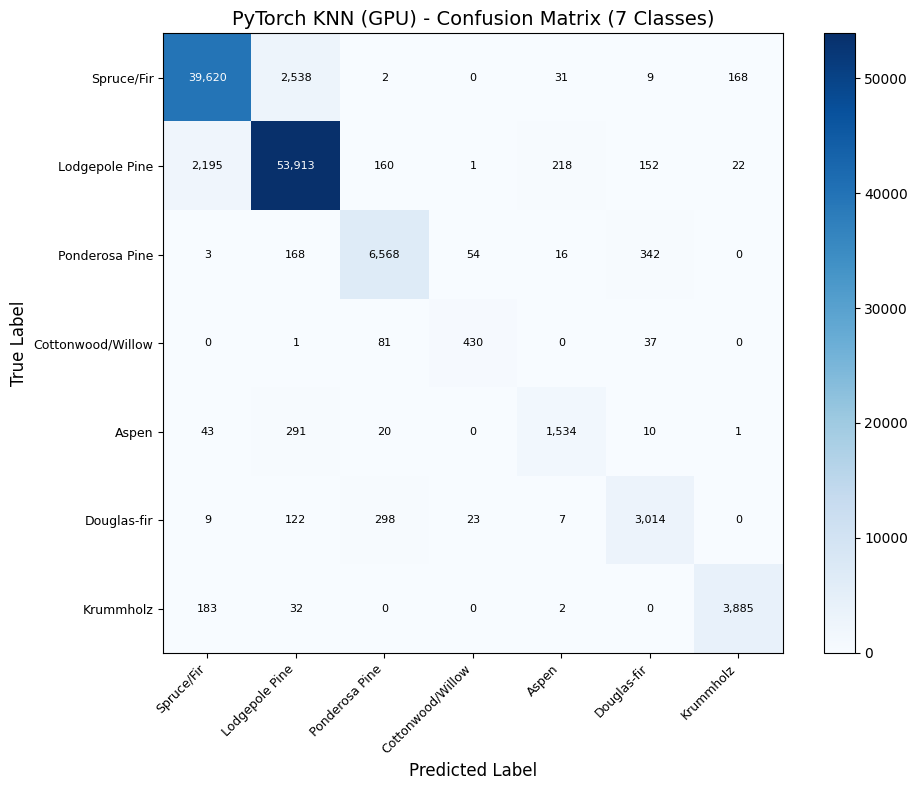

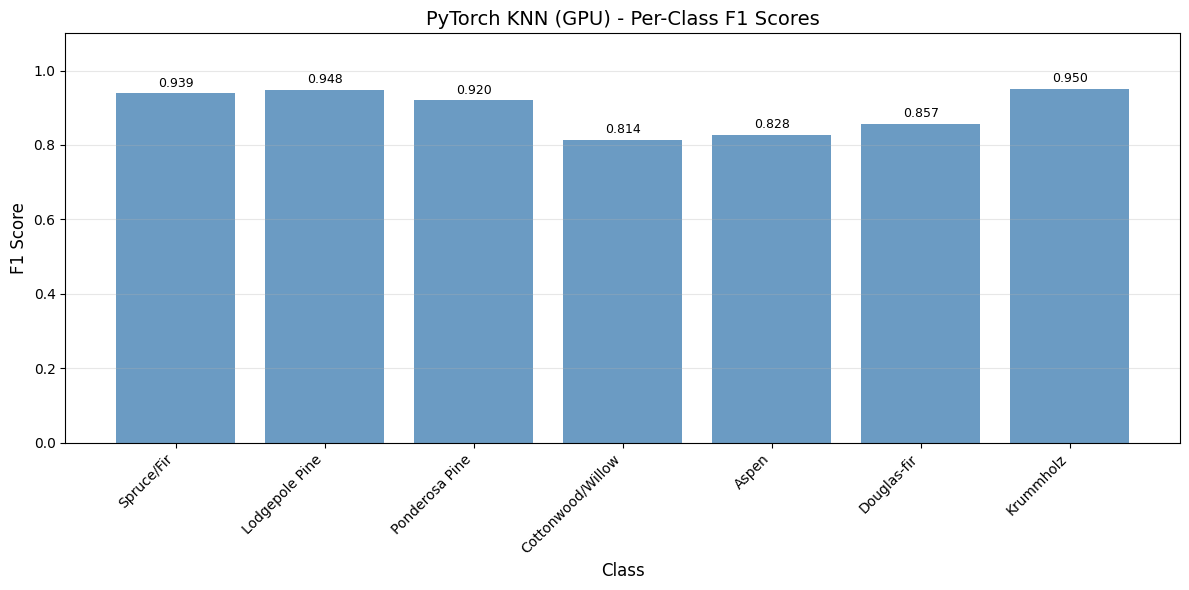

In [ ]:
# Visualizations
"""
Generate the same 3 visualizations as other frameworks for comparison:
1. Confusion matrix
2. Per-Class F1
3. Validation Curve - Skipped (We used scikit-learn's gridsearchcv results)
"""
# Confusion Matrix
plot_confusion_matrix_multiclass(
    y_true=y_test,
    y_pred=y_pred,
    class_names=class_names,
    framework='PyTorch KNN (GPU)',
    save_path='results/confusion_matrix.png'
)

# Per-Class F1 Scores
plot_per_class_f1(
    y_true=y_test,
    y_pred=y_pred,
    class_names=class_names,
    framework='PyTorch KNN (GPU)',
    save_path='results/per_class_f1.png'
)